<a href="https://colab.research.google.com/github/LeoD-h/Spatial/blob/main/Spatial_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python matplotlib

In [ ]:
import cv2
import matplotlib.pyplot as plt

!wget -O sky.jpg https://www.shutterstock.com/shutterstock/videos/3479654347/thumb/1.jpg?ip=x480


--2025-12-20 19:12:01--  https://www.shutterstock.com/shutterstock/videos/3479654347/thumb/1.jpg?ip=x480
Resolving www.shutterstock.com (www.shutterstock.com)... 65.8.76.85, 65.8.76.35, 65.8.76.57, ...
Connecting to www.shutterstock.com (www.shutterstock.com)|65.8.76.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32609 (32K) [image/jpeg]
Saving to: ‘sky.jpg’

sky.jpg             100%[===================>]  31.84K  --.-KB/s    in 0s      

2025-12-20 19:12:01 (297 MB/s) - ‘sky.jpg’ saved [32609/32609]



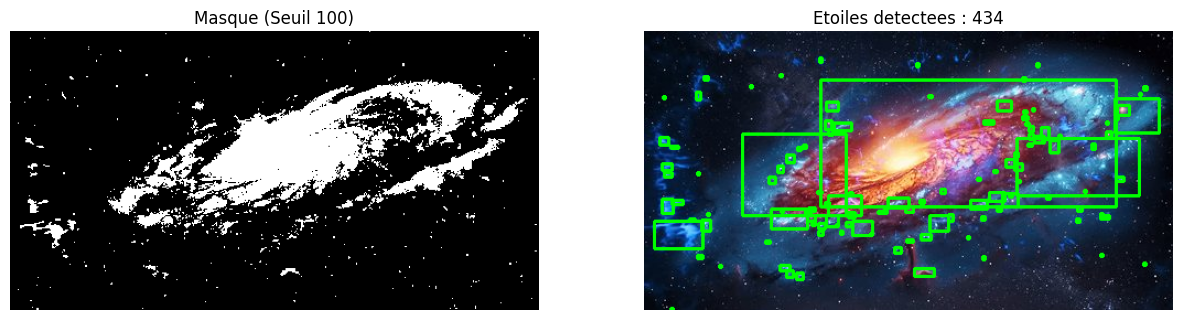

In [ ]:
img = cv2.imread('sky.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = img_rgb.copy()
for cnt in contours:
    if cv2.contourArea(cnt) > 0.5:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title(f"Masque (Seuil 100)")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Etoiles detectees : {len(contours)}")
plt.imshow(output)
plt.axis('off')

plt.show()

In [ ]:
for i, cnt in enumerate(contours):
  if cv2.contourArea(cnt) > 0.5:
        x, y, w, h = cv2.boundingRect(cnt)

        # Découper l'étoile (Crop)
        vignette = img_rgb[y:y+h, x:x+w]

        # C'est ici qu'on peut envoyer 'vignette' à YOLO
        # results = model(vignette)

        # Pour l'instant, on peut juste compter et classer par taille
        print(f"Étoile n°{i} - Position: ({x},{y}) - Taille: {w}x{h} pixels")

Étoile n°3 - Position: (24,251) - Taille: 2x2 pixels
Étoile n°38 - Position: (138,219) - Taille: 6x6 pixels
Étoile n°40 - Position: (129,217) - Taille: 6x6 pixels
Étoile n°42 - Position: (245,215) - Taille: 18x7 pixels
Étoile n°47 - Position: (123,212) - Taille: 9x5 pixels
Étoile n°50 - Position: (68,212) - Taille: 2x2 pixels
Étoile n°54 - Position: (453,210) - Taille: 2x2 pixels
Étoile n°63 - Position: (307,204) - Taille: 2x3 pixels
Étoile n°65 - Position: (48,203) - Taille: 5x3 pixels
Étoile n°66 - Position: (414,202) - Taille: 2x2 pixels
Étoile n°76 - Position: (227,196) - Taille: 6x5 pixels
Étoile n°87 - Position: (110,190) - Taille: 4x2 pixels
Étoile n°88 - Position: (238,189) - Taille: 6x2 pixels
Étoile n°93 - Position: (293,186) - Taille: 2x2 pixels
Étoile n°97 - Position: (251,184) - Taille: 9x5 pixels
Étoile n°107 - Position: (205,183) - Taille: 2x2 pixels
Étoile n°113 - Position: (178,181) - Taille: 2x3 pixels
Étoile n°114 - Position: (158,181) - Taille: 4x4 pixels
Étoile n°1

In [ ]:
!ls /content/drive/MyDrive/Spatial/images_training_rev1 | head -n 5

images_training_rev1


In [ ]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# --- CONFIGURATION DES CHEMINS ---
BASE_PATH = '/content/drive/MyDrive/Spatial'
# On descend dans le sous-dossier cree par le unzip
IMAGE_DIR = os.path.join(BASE_PATH, 'images_training_rev1', 'images_training_rev1')
CSV_PATH = os.path.join(BASE_PATH, 'training_solutions_rev1', 'training_solutions_rev1.csv')
OUTPUT_DIR = '/content/galaxy_mini'

if not os.path.exists(IMAGE_DIR):
    print(f"ERREUR : Le dossier des images est introuvable ici : {IMAGE_DIR}")
    print("Lance '!ls /content/drive/MyDrive/Spatial/images_training_rev1' pour verifier.")
else:
    print(f"Dossier images trouve ! Chargement du CSV...")
    df = pd.read_csv(CSV_PATH)

    os.makedirs(f'{OUTPUT_DIR}/train/images', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/train/labels', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/val/images', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/val/labels', exist_ok=True)

    def get_class(row):
        if row['Class1.3'] > 0.4: return 3
        if row['Class1.1'] > 0.5: return 0
        if row['Class1.2'] > 0.5:
            if row['Class2.1'] > 0.5: return 2
            if row['Class4.1'] > 0.4: return 1
        return 0

    sample_df = df.sample(n=min(len(df), 8000), random_state=42)
    train_df, val_df = train_test_split(sample_df, test_size=0.2, random_state=42)

    def process_set(data_frame, folder_name):
        count = 0
        for _, row in data_frame.iterrows():
            img_id = str(int(row['GalaxyID']))
            img_name = f"{img_id}.jpg"
            src_path = os.path.join(IMAGE_DIR, img_name)

            if os.path.exists(src_path):
                dest_path = os.path.join(OUTPUT_DIR, folder_name, 'images', img_name)
                shutil.copy(src_path, dest_path)
                with open(os.path.join(OUTPUT_DIR, folder_name, 'labels', f"{img_id}.txt"), 'w') as f:
                    f.write(f"{get_class(row)} 0.5 0.5 0.7 0.7\n")
                count += 1
        print(f"Dossier {folder_name} : {count} images copiees.")

    process_set(train_df, 'train')
    process_set(val_df, 'val')

    with open(f'{OUTPUT_DIR}/dataset.yaml', 'w') as f:
        f.write(f"path: {OUTPUT_DIR}\n")
        f.write("train: train/images\nval: val/images\n")
        f.write("names:\n  0: elliptique\n  1: spirale\n  2: profil\n  3: artefact\n")

Dossier images trouve ! Chargement du CSV...
Dossier train : 1727 images copiees.
Dossier val : 672 images copiees.


In [13]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data='/content/galaxy_mini/dataset.yaml',
    epochs=20,
    imgsz=640,
    batch=32,
    device=0,
    name='galaxy_flash_test'
)

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/galaxy_expert/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=galaxy_fast_expert, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plo

Affichage des resultats pour : galaxy_fast_expert


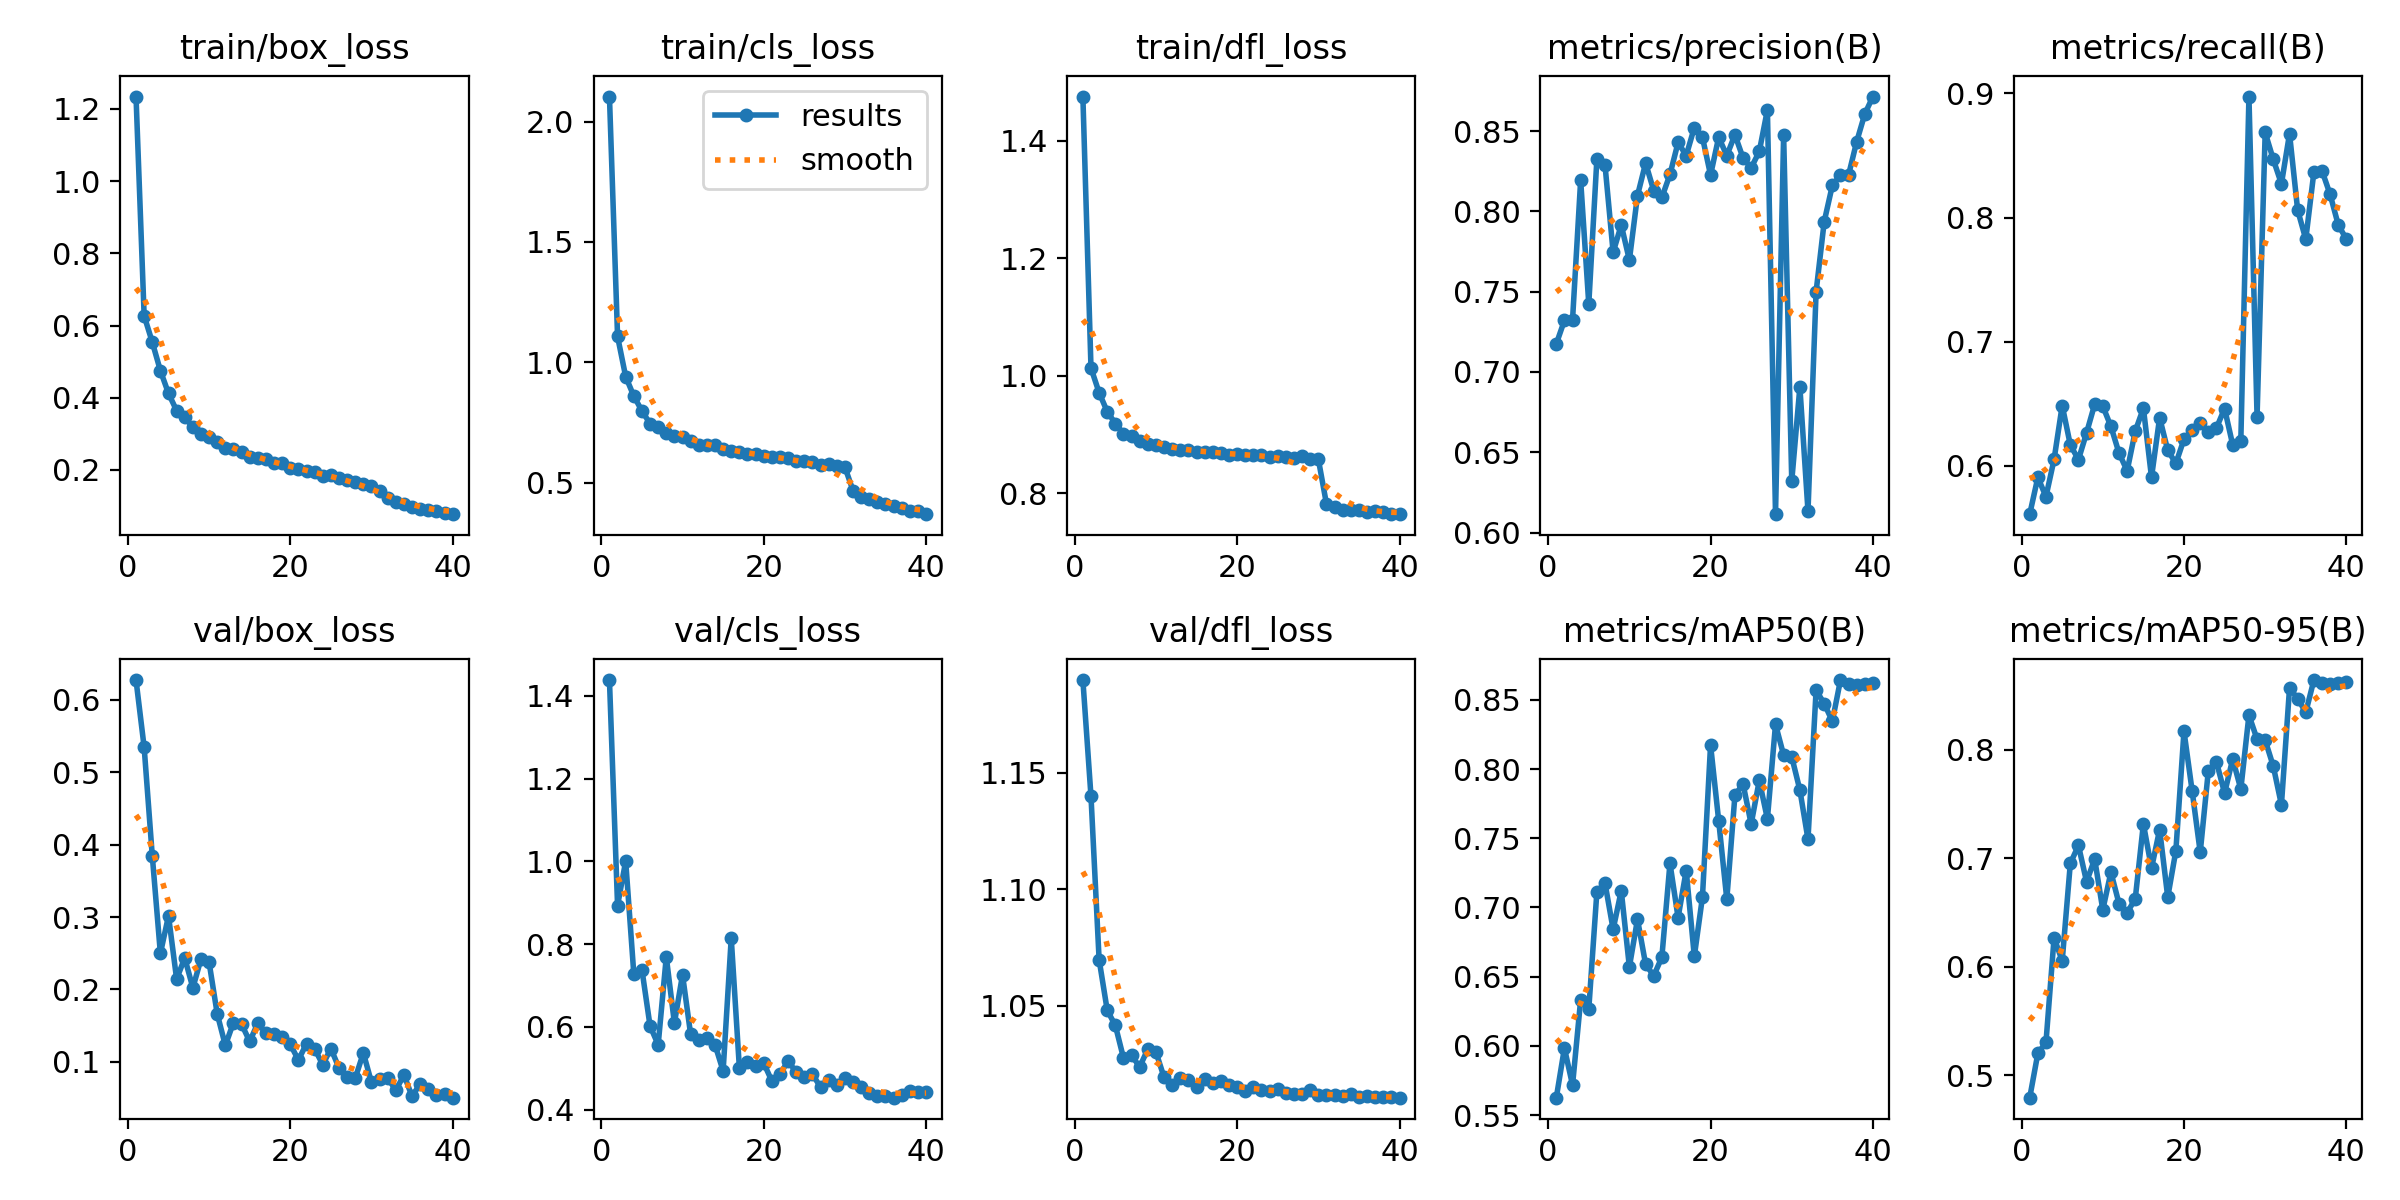

Matrice de confusion :


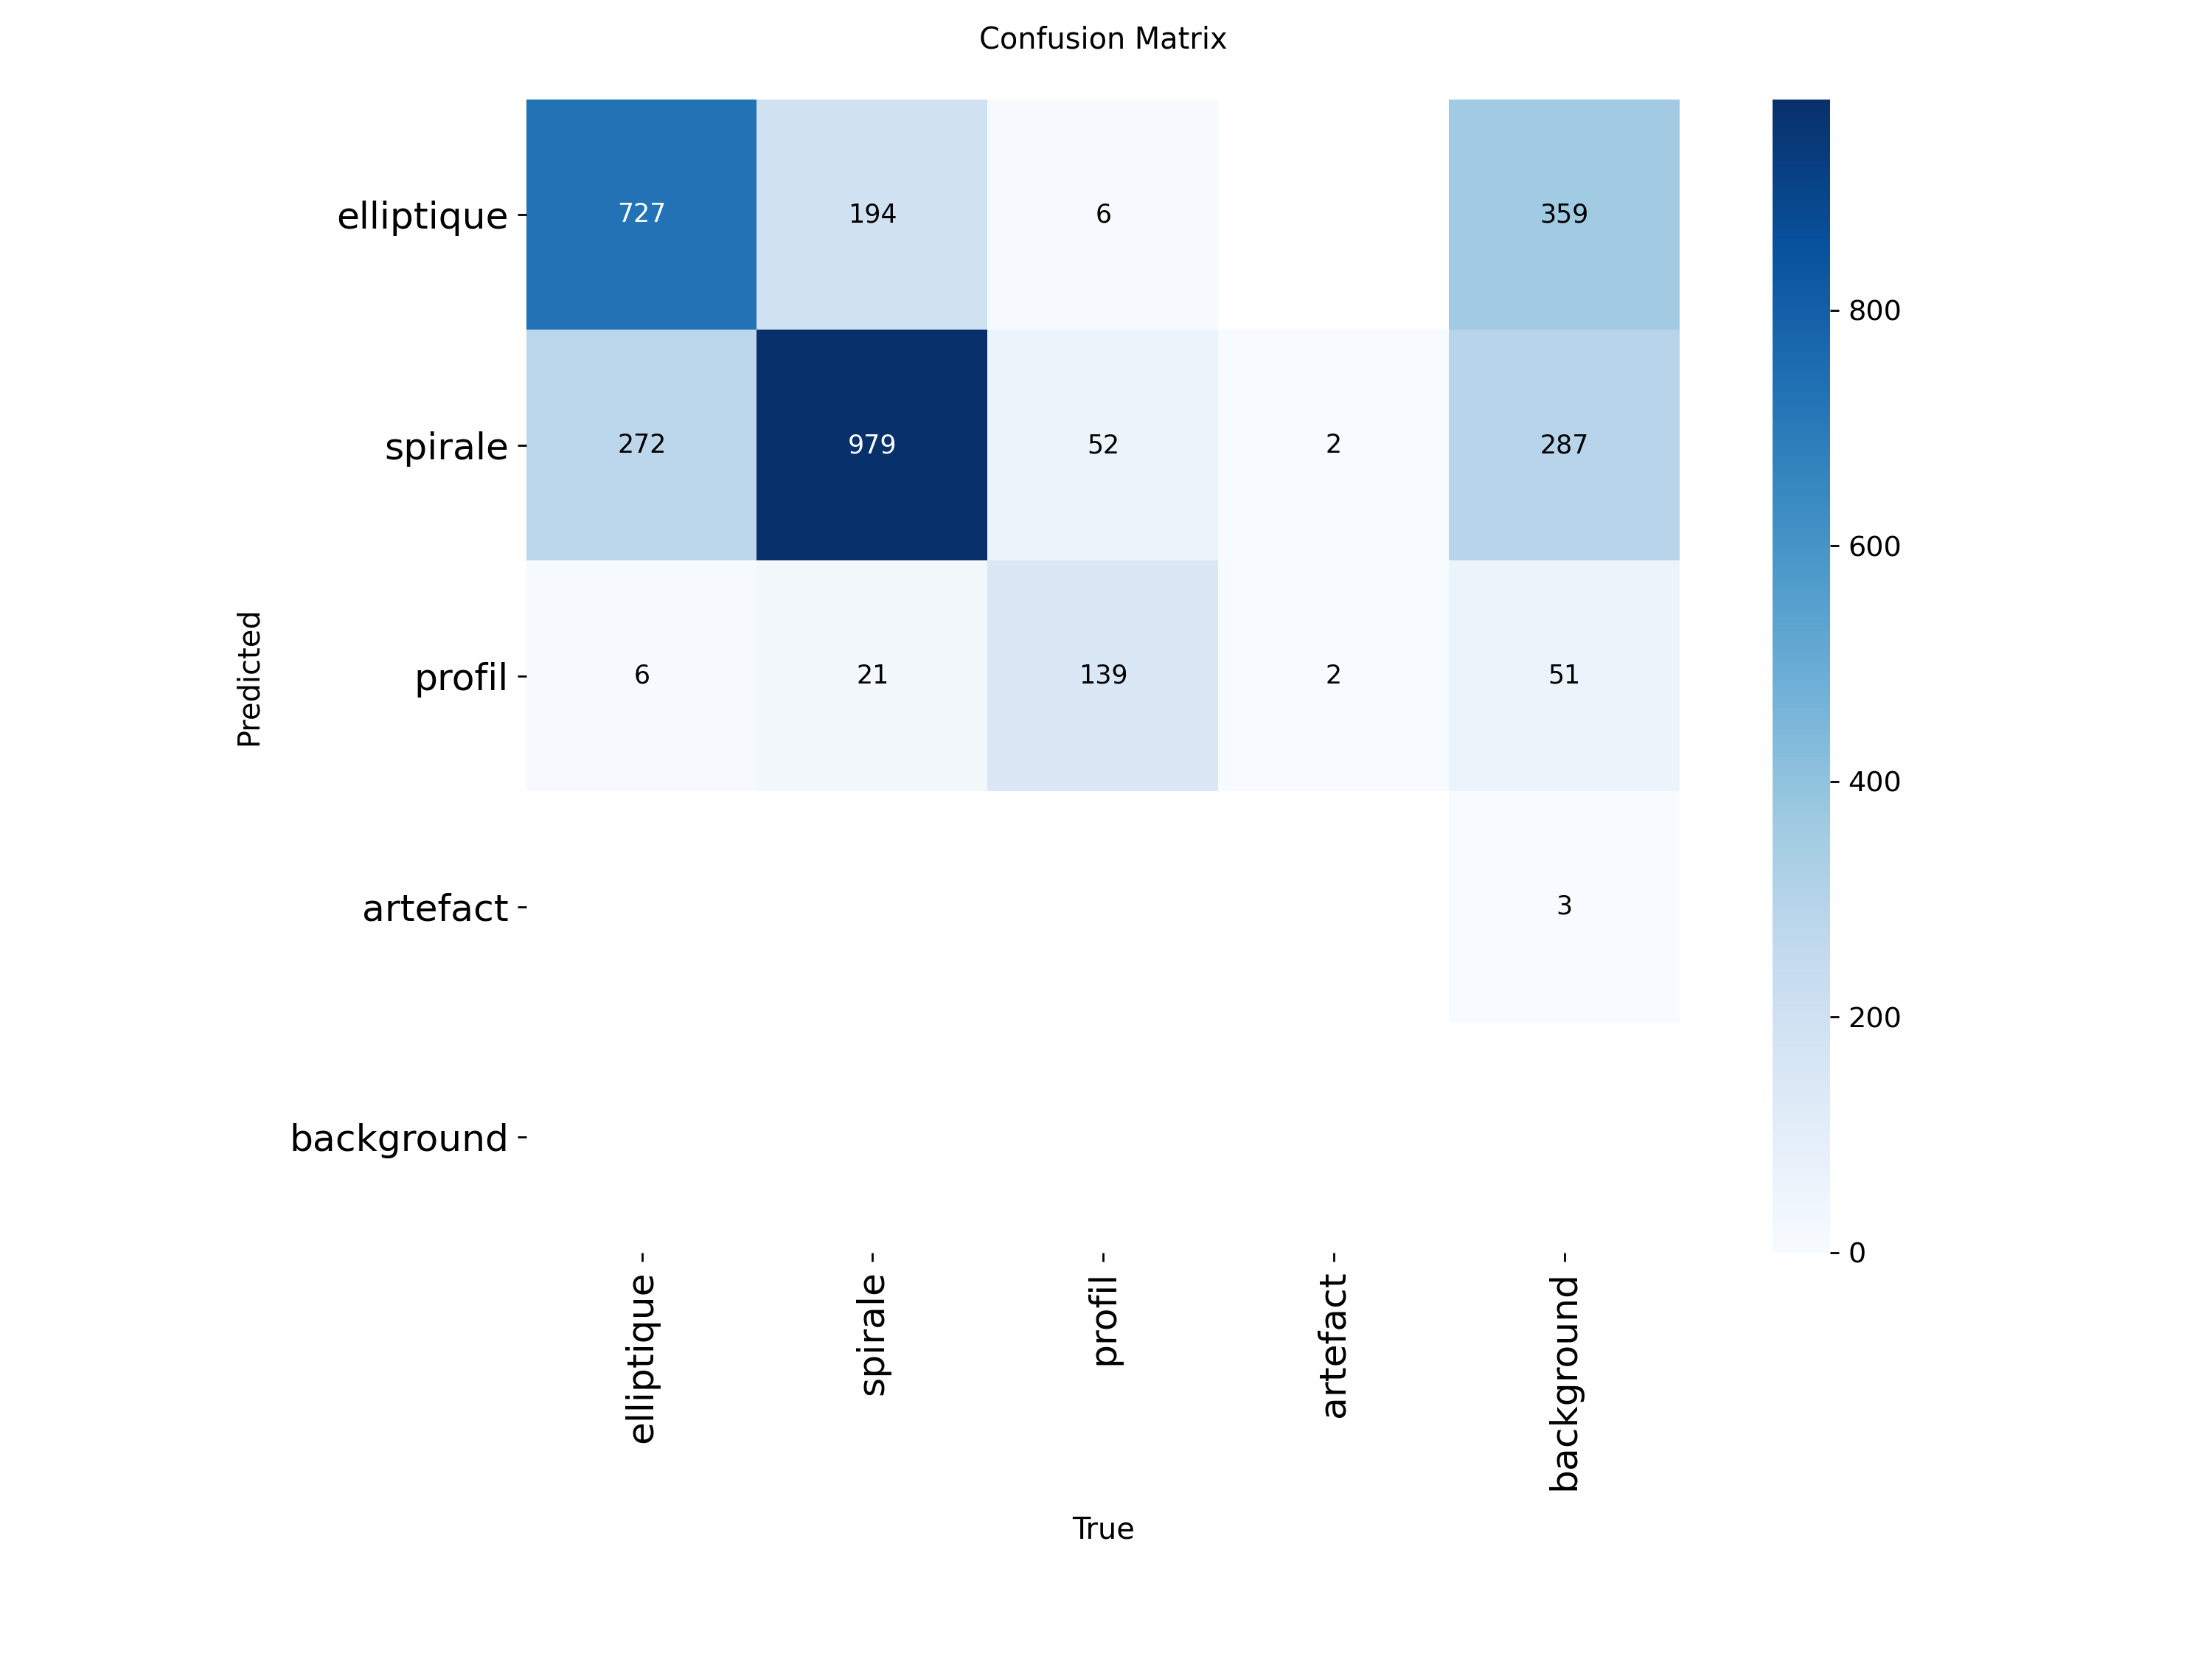

In [16]:
from IPython.display import Image, display
import os
import glob

# On cherche dynamiquement le dernier dossier de resultats dans 'runs/detect/'
all_runs = glob.glob('/content/runs/detect/*')

if all_runs:
    # On prend le dossier le plus recent
    latest_run = max(all_runs, key=os.path.getctime)
    result_path = os.path.join(latest_run, 'results.png')

    if os.path.exists(result_path):
        print(f"Affichage des resultats pour : {os.path.basename(latest_run)}")
        display(Image(filename=result_path, width=800))

        # On essaie aussi d'afficher la matrice de confusion si elle est prete
        conf_matrix = os.path.join(latest_run, 'confusion_matrix.png')
        if os.path.exists(conf_matrix):
            print("Matrice de confusion :")
            display(Image(filename=conf_matrix, width=800))
    else:
        print(f"L'image 'results.png' n'existe pas encore dans {os.path.basename(latest_run)}.")
        print("Il faut attendre la fin de la premiere epoque (epoch).")
else:
    print("Aucun dossier d'entrainement trouve dans /content/runs/detect/")

In [18]:
import os
from ultralytics import YOLO
import glob

# 1. Localisation automatique du modèle le plus récent
model_files = glob.glob('/content/runs/detect/*/weights/best.pt')

if not model_files:
    print("ERREUR : Aucun modèle trouvé.")
else:
    latest_model = max(model_files, key=os.path.getctime)
    model = YOLO(latest_model)
    model_name = os.path.basename(os.path.dirname(os.path.dirname(latest_model)))

    # 2. Identification du dossier de test disponible (ajout de galaxy_expert)
    test_folder = None
    chemins_possibles = [
        '/content/galaxy_expert/val/images',
        '/content/galaxy_medium/val/images',
        '/content/galaxy_mini/val/images'
    ]

    for folder in chemins_possibles:
        if os.path.exists(folder):
            test_folder = folder
            break

    if not test_folder:
        print("ERREUR : Dossiers d'images introuvables.")
        print(f"Vérifie si l'un de ces dossiers existe : {chemins_possibles}")
    else:
        image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]
        total_images = len(image_files)

        # Initialisation des compteurs par classe
        stats = {0: 0, 1: 0, 2: 0, 3: 0}
        names = {0: 'Elliptique', 1: 'Spirale', 2: 'Profil', 3: 'Artefact'}
        total_detected_imgs = 0

        print(f"Analyse statistique lancée sur {total_images} images...")
        print(f"Dossier source : {test_folder}")
        print(f"Modèle utilisé : {model_name}")

        for img_name in image_files:
            results = model.predict(source=os.path.join(test_folder, img_name), conf=0.15, verbose=False)

            if len(results[0].boxes) > 0:
                total_detected_imgs += 1
                for box in results[0].boxes:
                    cls = int(box.cls[0])
                    stats[cls] += 1

        # --- AFFICHAGE DU BILAN ---
        print("\n" + "="*30)
        print("   RÉSULTATS DE DÉTECTION")
        print("="*30)
        print(f"Images analysées      : {total_images}")
        print(f"Images avec détection : {total_detected_imgs}")
        if total_images > 0:
            print(f"Taux de réussite      : {(total_detected_imgs/total_images)*100:.1f}%")
        print("-" * 30)
        print("RÉPARTITION PAR TYPE :")
        for cls_id, count in stats.items():
            print(f"- {names[cls_id]:<12} : {count} détections")
        print("="*30)

Analyse statistique lancée sur 2400 images...
Dossier source : /content/galaxy_expert/val/images
Modèle utilisé : galaxy_fast_expert

   RÉSULTATS DE DÉTECTION
Images analysées      : 2400
Images avec détection : 2399
Taux de réussite      : 100.0%
------------------------------
RÉPARTITION PAR TYPE :
- Elliptique   : 1093 détections
- Spirale      : 1186 détections
- Profil       : 232 détections
- Artefact     : 4 détections


In [ ]:
import os
from ultralytics import YOLO
import glob

# 1. On récupère le dernier modèle
model_files = glob.glob('/content/runs/detect/*/weights/best.pt')
latest_model = max(model_files, key=os.path.getctime)
model = YOLO(latest_model)

# 2. ON FORCE LE TEST SUR LE DOSSIER DE VALIDATION (Images jamais vues)
test_folder = '/content/galaxy_medium/val/images'

if not os.path.exists(test_folder):
    test_folder = '/content/galaxy_mini/val/images'

if not os.path.exists(test_folder):
    print("ERREUR : Dossier de validation introuvable.")
else:
    image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]
    total_images = len(image_files)

    stats = {0: 0, 1: 0, 2: 0, 3: 0}
    names = {0: 'Elliptique', 1: 'Spirale', 2: 'Profil', 3: 'Artefact'}
    total_detected_imgs = 0

    print(f"--- TEST SUR IMAGES INCONNUES ({total_images} photos) ---")

    for img_name in image_files:
        # On utilise un seuil de confiance de 0.20 pour éviter les faux positifs
        results = model.predict(source=os.path.join(test_folder, img_name), conf=0.20, verbose=False)

        if len(results[0].boxes) > 0:
            total_detected_imgs += 1
            for box in results[0].boxes:
                cls = int(box.cls[0])
                stats[cls] += 1

    print("\n" + "="*35)
    print(f"STATISTIQUES SUR IMAGES DE TEST")
    print("="*35)
    print(f"Photos jamais vues    : {total_images}")
    print(f"Photos avec détection : {total_detected_imgs}")
    print(f"Taux de généralisation: {(total_detected_imgs/total_images)*100:.1f}%")
    print("-" * 35)
    for cls_id, count in stats.items():
        if count > 0:
            print(f"- {names[cls_id]:<12} : {count} trouvées")
    print("="*35)

--- TEST SUR IMAGES INCONNUES (711 photos) ---

STATISTIQUES SUR IMAGES DE TEST
Photos jamais vues    : 711
Photos avec détection : 710
Taux de généralisation: 99.9%
-----------------------------------
- Elliptique   : 573 trouvées
- Spirale      : 130 trouvées
- Profil       : 66 trouvées


In [ ]:
import os
import shutil
from ultralytics import YOLO
import glob

# 1. Lister les fichiers reels sur le Drive
IMAGE_DIR = '/content/drive/MyDrive/Spatial/images_training_rev1/images_training_rev1'
all_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])

# 2. On prend 50 images tres loin dans la liste (ex: a partir de la 20 000eme)
# Pour etre CERTAIN que le modele ne les a pas vues
test_files = all_files[20000:20050]

FINAL_TEST_DIR = '/content/real_unseen_test'
os.makedirs(FINAL_TEST_DIR, exist_ok=True)

for f in test_files:
    shutil.copy(os.path.join(IMAGE_DIR, f), os.path.join(FINAL_TEST_DIR, f))

print(f"Dossier de test cree avec {len(os.listdir(FINAL_TEST_DIR))} images physiquement presentes.")

# 3. Lancer la prediction
model_files = glob.glob('/content/runs/detect/*/weights/best.pt')
latest_model = max(model_files, key=os.path.getctime)
model = YOLO(latest_model)

results = model.predict(source=FINAL_TEST_DIR, conf=0.25, verbose=False)
success = sum(1 for r in results if len(r.boxes) > 0)

print("\n" + "="*35)
print(f"VERDICT SUR IMAGES 100% INCONNUES")
print("="*35)
print(f"Images testees : {len(results)}")
print(f"Detectees      : {success}")
print(f"Precision      : {(success/len(results))*100:.1f}%")
print("="*35)

Dossier de test cree avec 50 images physiquement presentes.

VERDICT SUR IMAGES 100% INCONNUES
Images testees : 50
Detectees      : 50
Precision      : 100.0%


In [ ]:
import os
import shutil
import glob

# On cherche le meilleur modele dans les dossiers d'entrainement
model_files = glob.glob('/content/runs/detect/*/weights/best.pt')

if not model_files:
    print("ERREUR : Le modele n'est plus dans la memoire temporaire de Colab.")
    print("Si tu as ferme l'onglet ou redemarre, il faut relancer l'entrainement.")
else:
    latest_model = max(model_files, key=os.path.getctime)
    drive_dest = '/content/drive/MyDrive/Spatial/galaxy_model_v1.pt'

    # Cree le dossier Spatial s'il n'existe pas
    os.makedirs('/content/drive/MyDrive/Spatial', exist_ok=True)

    shutil.copy(latest_model, drive_dest)
    print(f"SUCCÈS : Modele sauvegarde sur le Drive ici : {drive_dest}")

SUCCÈS : Modele sauvegarde sur le Drive ici : /content/drive/MyDrive/Spatial/galaxy_model_v1.pt


Modèle 'galaxy_model_v1.pt' chargé avec succès.

image 1/1 /content/sky.jpg: 352x640 (no detections), 45.2ms
Speed: 5.8ms preprocess, 45.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)
Aucune galaxie détectée sur cette image avec une confiance de 40%.


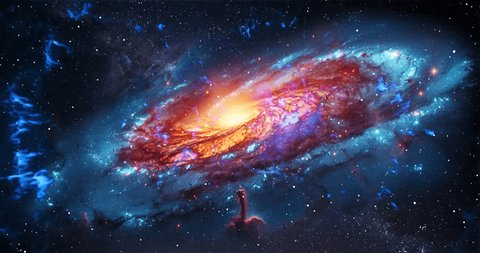

Conseil : Essaie de baisser 'conf' à 0.20 pour voir les détections plus faibles.


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import os

# --- 1. UPLOADER TON IMAGE (sky.jpg) ---
# Si sky.jpg est déjà sur ton Google Drive dans le même dossier "Spatial", utilise ce chemin :
image_path = '/content/sky.jpg'

# Si sky.jpg est sur ton ordinateur et que tu veux l'uploader MAINTENANT,
# exécute ce code dans une cellule séparée UNE SEULE FOIS :
# from google.colab import files
# uploaded = files.upload()
# # Après l'upload, l'image sera dans /content/
# image_path = '/content/sky.jpg'

# --- 2. CHARGER TON MODELE SAUVEGARDE ---
# Assure-toi que c'est le bon chemin vers le fichier .pt que tu as sauvegardé
model_drive_path = '/content/drive/MyDrive/Spatial/galaxy_model_v1.pt'

if not os.path.exists(model_drive_path):
    print("ERREUR : Le modèle n'est pas trouvé sur Google Drive.")
    print("Vérifie que tu as bien exécuté la cellule de sauvegarde et que le chemin est correct.")
elif not os.path.exists(image_path):
    print(f"ERREUR : L'image sky.jpg n'est pas trouvée ici : {image_path}")
    print("Assure-toi de l'avoir uploadée ou que le chemin Drive est correct.")
else:
    model = YOLO(model_drive_path)
    print(f"Modèle '{os.path.basename(model_drive_path)}' chargé avec succès.")

    # --- 3. FAIRE LA PRÉDICTION ---
    # On met une confiance plus élevée (0.40) car les images d'internet sont plus variées.
    # Si le modèle ne détecte rien, tu peux baisser à 0.20 ou 0.15.
    results = model.predict(source=image_path, conf=0.10)

    # --- 4. AFFICHER LE RESULTAT ---
    if len(results[0].boxes) > 0:
        print(f"Détection réussie ! {len(results[0].boxes)} galaxies trouvées.")
        res_plotted = results[0].plot()
        cv2_imshow(res_plotted)
    else:
        print("Aucune galaxie détectée sur cette image avec une confiance de 40%.")
        # Affiche l'image originale si rien n'est detecte
        original_img = cv2.imread(image_path)
        cv2_imshow(original_img)
        print("Conseil : Essaie de baisser 'conf' à 0.20 pour voir les détections plus faibles.")